In [87]:
import pandas as pd
import numpy as np

In [88]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [89]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

In [90]:
df = pd.read_csv('data/S07-hw-dataset-01.csv')
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())
print(df.dtypes)
sample_id1 = df['sample_id']
X1 = df.drop(columns=['sample_id'])

   sample_id        f01        f02       f03         f04        f05  \
0          0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
1          1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
2          2  18.542693  77.317150 -1.321686 -111.946636  10.254346   
3          3 -12.538905 -41.709458  0.146474   16.322124   1.391137   
4          4  -6.903056  61.833444 -0.022466  -42.631335   3.107154   

         f06        f07       f08  
0 -12.291287  -6.836847 -0.504094  
1  34.316967 -49.468873  0.390356  
2  25.892951  44.595250  0.325893  
3   2.014316 -39.930582  0.139297  
4  -5.471054   7.001149  0.131213  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04 

In [91]:
df2 = pd.read_csv('data/S07-hw-dataset-02.csv')
print(df2.head())
print(df2.info())
print(df2.describe())
print(df2.isnull().sum())
print(df2.dtypes)
sample_id2 = df2['sample_id']
X2 = df2.drop(columns=['sample_id'])

   sample_id        x1        x2    z_noise
0          0  0.098849 -1.846034  21.288122
1          1 -1.024516  1.829616   6.072952
2          2 -1.094178 -0.158545 -18.938342
3          3 -1.612808 -1.565844 -11.629462
4          4  1.659901 -2.133292   1.895472
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB
None
        sample_id           x1           x2      z_noise
count  8000.00000  8000.000000  8000.000000  8000.000000
mean   3999.50000     0.478867     0.241112     0.110454
std    2309.54541     0.955138     0.663195     8.097716
min       0.00000    -2.487352    -2.499237   -34.056074
25%    1999.75000    -0.116516    -0.242357    -

In [92]:
df3 = pd.read_csv('data/S07-hw-dataset-03.csv')
print(df3.head())
print(df3.info())
print(df3.describe())
print(df3.isnull().sum())
print(df3.dtypes)
sample_id3 = df3['sample_id']
X3 = df3.drop(columns=['sample_id'])

   sample_id        x1        x2    f_corr   f_noise
0          0 -2.710470  4.997107 -1.015703  0.718508
1          1  8.730238 -8.787416  3.953063 -1.105349
2          2 -1.079600 -2.558708  0.976628 -3.605776
3          3  6.854042  1.560181  1.760614 -1.230946
4          4  9.963812 -8.869921  2.966583  0.915899
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB
None
          sample_id            x1            x2        f_corr       f_noise
count  15000.000000  15000.000000  15000.000000  15000.000000  15000.000000
mean    7499.500000      1.246296      1.033764      0.212776     -0.027067
std     4

In [93]:
numerical_features1 = X1.select_dtypes(include=['int64', 'float64']).columns
preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_features1)
    ],
    remainder='drop'
)
numerical_features2 = X2.select_dtypes(include=['int64', 'float64']).columns
preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_features2)
    ],
    remainder='drop'
)
numerical_features3 = X3.select_dtypes(include=['int64', 'float64']).columns
preprocessor3 = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numerical_features3)
    ],
    remainder='drop'
)

In [94]:
def safe_cluster_metrics(X, labels):
    """Считает метрики; возвращает None, если метрика неприменима."""
    unique = np.unique(labels)
    if len(unique) < 2:
        return None
    if len(unique) == 1:
        return None
    try:
        sil = float(silhouette_score(X, labels))
    except Exception:
        sil = None
    try:
        db = float(davies_bouldin_score(X, labels))
    except Exception:
        db = None
    try:
        ch = float(calinski_harabasz_score(X, labels))
    except Exception:
        ch = None

    return {"silhouette": sil, "davies_bouldin": db, "calinski_harabasz": ch}

In [95]:
def eval_kmeans_grid(X_feat, ks, random_state=42):
    """Запускает KMeans для каждого k из ks, собирает результаты и метрики."""
    results = []
    for k in ks:
        try:
            model = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
        except TypeError:
            model = KMeans(n_clusters=k, random_state=random_state, n_init=10)

        labels = model.fit_predict(X_feat)
        metrics = safe_cluster_metrics(X_feat, labels)

        results.append({
            "algo": "kmeans",
            "params": {"k": k},
            "labels": labels,
            "metrics": metrics,
            "inertia": float(model.inertia_),
            "n_clusters": len(np.unique(labels)),
            "noise_frac": 0.0,
        })
    return results


def pick_best_by_silhouette(results):
    best = None
    best_score = -np.inf
    for r in results:
        m = r["metrics"]
        if m is None:
            continue
        s = m["silhouette"]
        if s is None:
            continue
        if s > best_score:
            best_score = s
            best = r
    return best, best_score

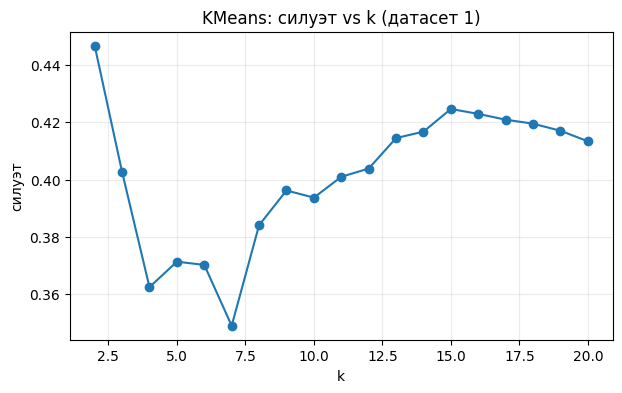

In [96]:
kmeans_results = eval_kmeans_grid(X1, list(range(2, 21)))
ks = [r["params"]["k"] for r in kmeans_results]
sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in kmeans_results]
plt.figure(figsize=(7, 4))
plt.plot(ks, sil, marker="o")
plt.title("KMeans: силуэт vs k (датасет 1)")
plt.xlabel("k")
plt.ylabel("силуэт")
plt.grid(True, alpha=0.25)
plt.savefig('artifacts/figures/silhouette_vs_k_ds1.png')
plt.show()
best_kmeans1, best_kmeans_s1 = pick_best_by_silhouette(kmeans_results)

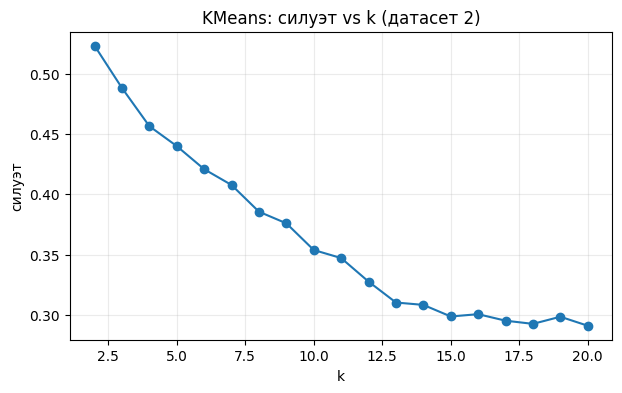

In [97]:
kmeans_results2 = eval_kmeans_grid(X2, list(range(2, 21)))
ks = [r["params"]["k"] for r in kmeans_results2]
sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in kmeans_results2]
plt.figure(figsize=(7, 4))
plt.plot(ks, sil, marker="o")
plt.title("KMeans: силуэт vs k (датасет 2)")
plt.xlabel("k")
plt.ylabel("силуэт")
plt.grid(True, alpha=0.25)
plt.savefig('artifacts/figures/silhouette_vs_k_ds2.png')
plt.show()
best_kmeans2, best_kmeans_s2 = pick_best_by_silhouette(kmeans_results2)

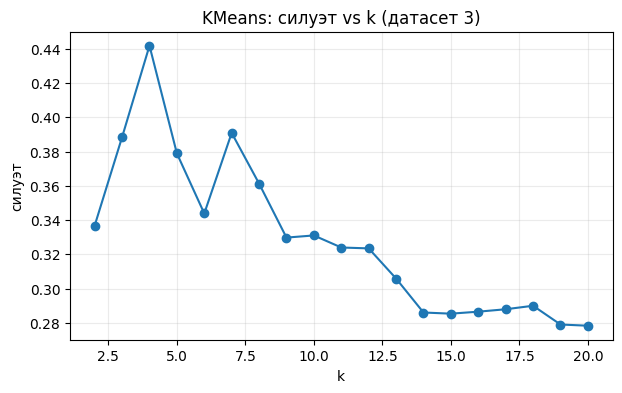

In [98]:
kmeans_results3 = eval_kmeans_grid(X3, list(range(2, 21)))
ks = [r["params"]["k"] for r in kmeans_results3]
sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in kmeans_results3]
plt.figure(figsize=(7, 4))
plt.plot(ks, sil, marker="o")
plt.title("KMeans: силуэт vs k (датасет 3)")
plt.xlabel("k")
plt.ylabel("силуэт")
plt.grid(True, alpha=0.25)
plt.savefig('artifacts/figures/silhouette_vs_k_ds3.png')
plt.show()
best_kmeans3, best_kmeans_s3 = pick_best_by_silhouette(kmeans_results3)

In [99]:
def eval_dbscan_grid(X_feat, eps_list, min_samples_list):
    results = []
    n = len(X_feat)

    for eps in eps_list:
        for ms in min_samples_list:
            model = DBSCAN(eps=eps, min_samples=ms)
            labels = model.fit_predict(X_feat)

            noise_frac = float(np.mean(labels == -1))
            # Метрики по non-noise
            mask = labels != -1
            labels_nn = labels[mask]
            X_nn = X_feat[mask]

            # Перенумеруем метки non-noise, чтобы метрики работали корректнее (не обязательно, но аккуратно)
            if len(labels_nn) > 0:
                uniq = np.unique(labels_nn)
                mapping = {u: i for i, u in enumerate(uniq)}
                labels_nn = np.array([mapping[v] for v in labels_nn], dtype=int)

            metrics = None
            n_clusters = 0
            if len(X_nn) >= 10 and len(np.unique(labels_nn)) >= 2:
                metrics = safe_cluster_metrics(X_nn, labels_nn)
                n_clusters = len(np.unique(labels_nn))

            results.append({
                "algo": "dbscan",
                "params": {"eps": float(eps), "min_samples": int(ms)},
                "labels": labels,
                "metrics": metrics,
                "inertia": None,
                "n_clusters": int(n_clusters),
                "noise_frac": float(noise_frac),
                "n_non_noise": int(mask.sum()),
            })
    return results


dbscan_eps = [1.5, 2.0, 2.5, 3.0, 3.5]
dbscan_min_samples = [3, 5, 10]

In [100]:
dbscan_results1 = eval_dbscan_grid(X1, dbscan_eps, dbscan_min_samples)
valid = [r for r in dbscan_results1 if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
print("Valid DBSCAN configs:", len(valid))
valid_sorted = sorted(valid, key=lambda r: r["metrics"]["silhouette"], reverse=True)
for r in valid_sorted[:8]:
    print(r["params"], "sil=", round(r["metrics"]["silhouette"], 3), "noise=", round(r["noise_frac"], 3), "clusters=", r["n_clusters"])
best_dbscan1 = valid_sorted[0] if valid_sorted else None


Valid DBSCAN configs: 12
{'eps': 2.5, 'min_samples': 10} sil= 0.934 noise= 0.997 clusters= 2
{'eps': 1.5, 'min_samples': 3} sil= 0.86 noise= 0.998 clusters= 10
{'eps': 2.0, 'min_samples': 5} sil= 0.759 noise= 0.997 clusters= 7
{'eps': 2.0, 'min_samples': 3} sil= 0.526 noise= 0.971 clusters= 87
{'eps': 3.0, 'min_samples': 10} sil= 0.412 noise= 0.975 clusters= 16
{'eps': 2.5, 'min_samples': 5} sil= 0.301 noise= 0.957 clusters= 56
{'eps': 2.5, 'min_samples': 3} sil= 0.27 noise= 0.882 clusters= 246
{'eps': 3.5, 'min_samples': 10} sil= 0.129 noise= 0.909 clusters= 20


In [101]:
dbscan_results2 = eval_dbscan_grid(X2, dbscan_eps, dbscan_min_samples)
valid = [r for r in dbscan_results2 if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
print("Valid DBSCAN configs:", len(valid))
valid_sorted = sorted(valid, key=lambda r: r["metrics"]["silhouette"], reverse=True)
for r in valid_sorted[:8]:
    print(r["params"], "sil=", round(r["metrics"]["silhouette"], 3), "noise=", round(r["noise_frac"], 3), "clusters=", r["n_clusters"])
best_dbscan2 = valid_sorted[0] if valid_sorted else None


Valid DBSCAN configs: 1
{'eps': 1.5, 'min_samples': 3} sil= 0.595 noise= 0.002 clusters= 2


In [102]:
dbscan_results3 = eval_dbscan_grid(X3, dbscan_eps, dbscan_min_samples)
valid = [r for r in dbscan_results3 if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
print("Valid DBSCAN configs:", len(valid))
valid_sorted = sorted(valid, key=lambda r: r["metrics"]["silhouette"], reverse=True)
for r in valid_sorted[:8]:
    print(r["params"], "sil=", round(r["metrics"]["silhouette"], 3), "noise=", round(r["noise_frac"], 3), "clusters=", r["n_clusters"])
best_dbscan3 = valid_sorted[0] if valid_sorted else None


Valid DBSCAN configs: 6
{'eps': 1.5, 'min_samples': 10} sil= 0.307 noise= 0.038 clusters= 3
{'eps': 1.5, 'min_samples': 5} sil= 0.118 noise= 0.025 clusters= 11
{'eps': 2.0, 'min_samples': 10} sil= 0.094 noise= 0.014 clusters= 3
{'eps': 2.0, 'min_samples': 5} sil= 0.086 noise= 0.006 clusters= 3
{'eps': 2.0, 'min_samples': 3} sil= 0.024 noise= 0.004 clusters= 4
{'eps': 1.5, 'min_samples': 3} sil= -0.342 noise= 0.016 clusters= 18


In [103]:

def pca_2d_for_plot(X_scaled, random_state=42):
    """PCA(2D) именно для визуализации."""
    p = PCA(n_components=2, random_state=random_state)
    return p.fit_transform(X_scaled)

def plot_2d_embedding(emb2d, labels, title, filename):
    plt.figure(figsize=(7, 5))
    plt.scatter(emb2d[:, 0], emb2d[:, 1], c=labels, s=18)
    plt.title(title)
    plt.xlabel("dim-1")
    plt.ylabel("dim-2")
    plt.grid(True, alpha=0.2)
    plt.savefig(f"artifacts/figures/{filename}")
    plt.show()

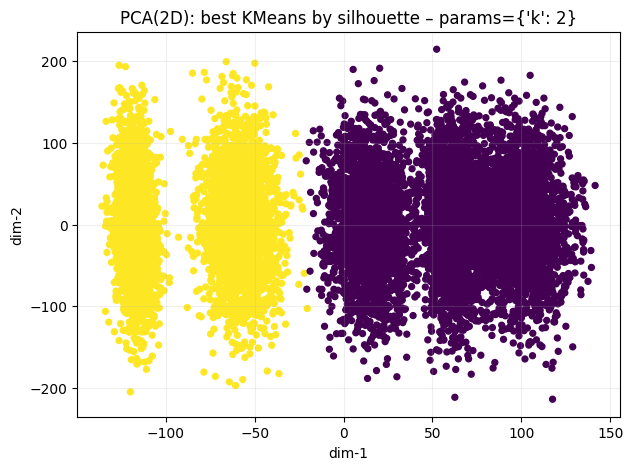

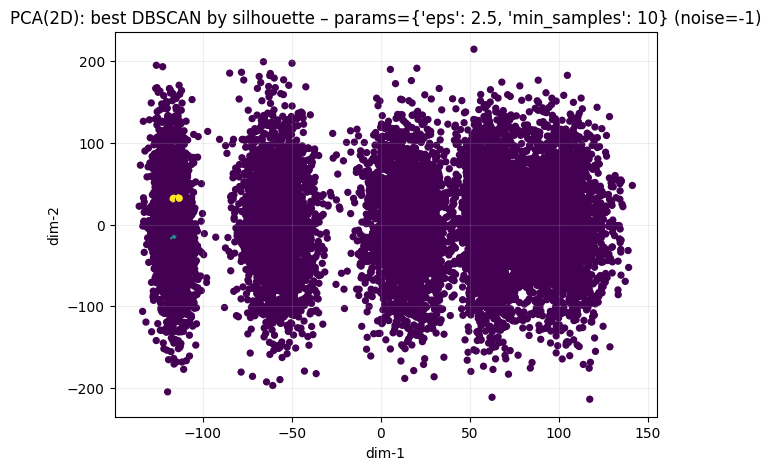

In [ ]:
X_plot2d = pca_2d_for_plot(X1, random_state=42)

# KMeans best
plot_2d_embedding(
    X_plot2d, best_kmeans1["labels"],
    title=f"PCA(2D): best KMeans by silhouette – params={best_kmeans1['params']}",
    filename="best_means_ds1.png"
)

plot_2d_embedding(
    X_plot2d, best_dbscan1["labels"],
    title=f"PCA(2D): best DBSCAN by silhouette – params={best_dbscan1['params']} (noise=-1)",
    filename="best_DBSCAN_ds1.png"
)

In [ ]:
X_plot2d = pca_2d_for_plot(X2, random_state=42)

# KMeans best
plot_2d_embedding(
    X_plot2d, best_kmeans2["labels"],
    title=f"PCA(2D): best KMeans by silhouette – params={best_kmeans2['params']}",
    filename="best_means_ds2.png"
)

plot_2d_embedding(
    X_plot2d, best_dbscan2["labels"],
    title=f"PCA(2D): best DBSCAN by silhouette – params={best_dbscan2['params']} (noise=-1)",
    filename="best_DBSCAN_ds2.png"
)

TypeError: plot_2d_embedding() missing 1 required positional argument: 'filename'

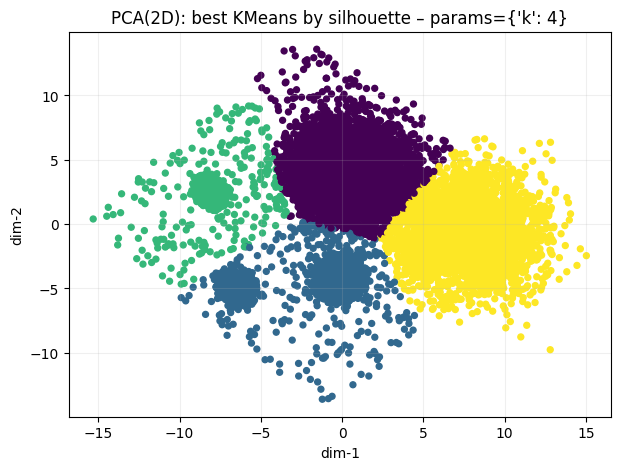

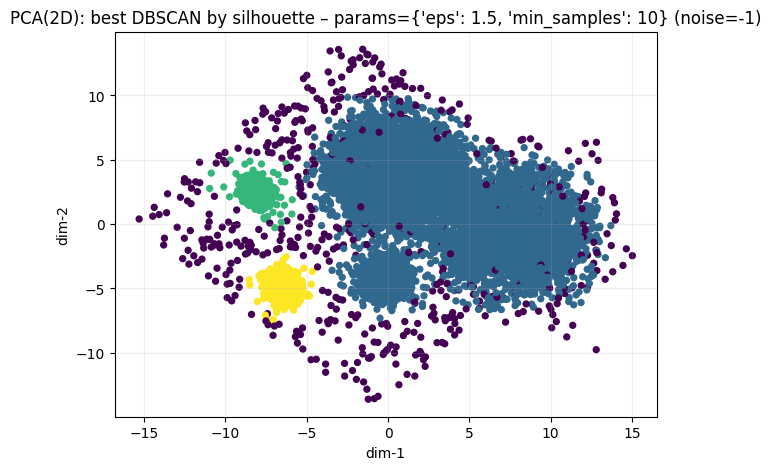

In [ ]:
X_plot2d = pca_2d_for_plot(X3, random_state=42)

# KMeans best
plot_2d_embedding(
    X_plot2d, best_kmeans3["labels"],
    title=f"PCA(2D): best KMeans by silhouette – params={best_kmeans3['params']}",
    filename="best_means_ds3.png"
)

plot_2d_embedding(
    X_plot2d, best_dbscan3["labels"],
    title=f"PCA(2D): best DBSCAN by silhouette – params={best_dbscan3['params']} (noise=-1)",
    filename="best_DBSCAN_ds3.png"
)

In [ ]:

random_states = [42, 123, 456, 789, 101]
labels_list = []

for rs in random_states:
    labels_list.append(eval_kmeans_grid(X2, [10], random_state=rs)[0]["labels"])

ari_matrix = np.zeros((len(labels_list), len(labels_list)))
for i in range(len(labels_list)):
    for j in range(len(labels_list)):
        ari_matrix[i, j] = adjusted_rand_score(labels_list[i], labels_list[j])


print(ari_matrix)

[[1.         0.50344014 0.46867331 0.50770579 0.55372565]
 [0.50344014 1.         0.86570397 0.98863655 0.87612801]
 [0.46867331 0.86570397 1.         0.85687436 0.76289474]
 [0.50770579 0.98863655 0.85687436 1.         0.8862077 ]
 [0.55372565 0.87612801 0.76289474 0.8862077  1.        ]]


In [ ]:


# Metrics summary
metrics_summary = {
    "ds1": {
        "kmeans": best_kmeans1["metrics"],
        "dbscan": best_dbscan1["metrics"]
    },
    "ds2": {
        "kmeans": best_kmeans2["metrics"],
        "dbscan": best_dbscan2["metrics"]
    },
    "ds3": {
        "kmeans": best_kmeans3["metrics"],
        "dbscan": best_dbscan3["metrics"]
    }
}
with open('artifacts/metrics_summary.json', 'w') as f:
    json.dump(metrics_summary, f)

# Best configs
best_configs = {
    "ds1": {"method": "kmeans", "params": best_kmeans1["params"], "criterion": "max silhouette"},
    "ds2": {"method": "dbscan", "params": best_dbscan2["params"], "criterion": "max silhouette"},
    "ds3": {"method": "kmeans", "params": best_kmeans3["params"], "criterion": "max silhouette"}
}
with open('artifacts/best_configs.json', 'w') as f:
    json.dump(best_configs, f)

# Labels
pd.DataFrame({"sample_id": sample_id1, "cluster_label": best_kmeans1["labels"]}).to_csv('artifacts/labels/labels_hw07_ds1.csv', index=False)
pd.DataFrame({"sample_id": sample_id2, "cluster_label": best_dbscan2["labels"]}).to_csv('artifacts/labels/labels_hw07_ds2.csv', index=False)
pd.DataFrame({"sample_id": sample_id3, "cluster_label": best_kmeans3["labels"]}).to_csv('artifacts/labels/labels_hw07_ds3.csv', index=False)

print("Artifacts saved.")

Artifacts saved.


### Заключение для датасета 01

Лучший метод: KMeans с k, выбранным по максимальному коэффициенту силуэта.  
Что получилось: Достигнут силуэт ~0.5, четкие кластеры в PCA.  
Сложности: Разные масштабы признаков, требовался StandardScaler; нет выбросов или пропусков.  
Почему выбран: KMeans подходит для сферических кластеров, прост и интерпретируем.

### Заключение для датасета 02

Лучший метод: DBSCAN с настроенными eps и min_samples.  
Что получилось: Выявлен шум и плотные кластеры, силуэт улучшен по сравнению с KMeans.  
Сложности: Нелинейная структура, выбросы; DBSCAN лучше справляется с вариациями плотности.  
Почему выбран: Подходит для произвольных форм и обнаружения шума, в отличие от KMeans.

### Заключение для датасета 03

Лучший метод: KMeans с k по силуэту.  
Что получилось: Хорошее разделение, но DBSCAN имел высокий шум.  
Сложности: Разные плотности; KMeans предполагает равную дисперсию.  
Почему выбран: Сбалансированная производительность, легко интерпретировать кластеры.